In [1]:
%pylab inline --no-import-all
import seaborn as sns
import scipy as sp
import scipy.ndimage
import os
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, AveragePooling2D
from keras.optimizers import SGD
from keras.datasets import mnist

Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


Load MNIST dataset and convert result to numpy arrays

In [2]:
(trainX, trainY), (testX, testY) = mnist.load_data()
train_samples = trainX.shape[0]
test_samples = testX.shape[0]

trainX = trainX.reshape((train_samples, 28*28))
testX = testX.reshape((test_samples, 28*28))
trainY = keras.utils.to_categorical(trainY, num_classes=10)

print("train set size: %d" % train_samples)
print("test set size: %d" % test_samples)

train set size: 60000
test set size: 10000


First let's create multiple layer perceptron

In [4]:
mlp_model = Sequential([
    Dense(64, input_shape=(784,), kernel_initializer='random_uniform'),
    Activation('relu'),
    Dropout(0.125),
    Dense(64, kernel_initializer='random_uniform'),
    Activation('relu'),
    Dense(10, kernel_initializer='random_uniform'),
    Activation('softmax'),
])

mlp_model.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Training the model

In [5]:
mlp_model.fit(trainX, trainY, epochs=10, batch_size=30)

Epoch 1/10
60000/60000 [==============================] - 14s - loss: 0.3773 - acc: 0.8865    
Epoch 2/10
60000/60000 [==============================] - 3s - loss: 0.2149 - acc: 0.9363     
Epoch 3/10
60000/60000 [==============================] - 3s - loss: 0.1815 - acc: 0.9469     
Epoch 4/10
60000/60000 [==============================] - 3s - loss: 0.1656 - acc: 0.9515     
Epoch 5/10
60000/60000 [==============================] - 4s - loss: 0.1488 - acc: 0.9572     
Epoch 6/10
60000/60000 [==============================] - 3s - loss: 0.1419 - acc: 0.9578     
Epoch 7/10
60000/60000 [==============================] - 4s - loss: 0.1327 - acc: 0.9608     
Epoch 8/10
60000/60000 [==============================] - 4s - loss: 0.1316 - acc: 0.9622     
Epoch 9/10
60000/60000 [==============================] - 4s - loss: 0.1225 - acc: 0.9644     
Epoch 10/10
60000/60000 [==============================] - 4s - loss: 0.1249 - acc: 0.9639     


Define some helper functions

In [6]:
def decode_one_hot(encoded):
    return np.apply_along_axis(np.argmax, axis=1, arr=encoded)

def evaluate_accuracy(predicted, expected): 
    return ("model accuracy on test data: {:.3f}%"
            .format(100 * (1.0 - (predicted != expected).sum() / expected.shape[0])) )

Predict output values for test samples and evaluate model accuracy

In [7]:
mlp_predictions = mlp_model.predict(testX)

decoded_mlp_predictions = decode_one_hot(mlp_predictions)
expected = testY.reshape(test_samples)

print(evaluate_accuracy(decoded_mlp_predictions, expected))

model accuracy on test data: 96.550%


Test error is almost equal, so this means that there's no overfitting.
Anyway 97% is not accurate enough, but isn't so bad for the first time

Now let's see how frequently certain digits were not recognized and what's was recognized instead 

In [8]:
import matplotlib.patches as mpatches

def error_plot(predictions, true):
    def what_is_predicted(predictions, instead_of):
        return predictions[np.all(
            (predictions != true, true == instead_of),
            axis=0)]

    fig, ax = plt.subplots(figsize=(14, 10), dpi=80)
    colors = [
        "#B76C6C",
        "#B78B6C",
        "#B3B76C",
        "#90B76C",
        "#6CB77E",
        "#6CB7B2",
        "#6C96B7",
        "#6C76B7",
        "#906CB7",
        "#B76CB5"
    ]
    plt.xticks(np.arange(10), size=16)
    plt.xlabel("What should be", size=20)
    plt.ylabel("Wrong predictions", size=20)


    wrong_numbers = [np.bincount(what_is_predicted(predictions, i)) for i in range(0, 10)]
    result = []
    for i, num in enumerate(wrong_numbers):
        bottom = 0
        for j, error in enumerate(num):
            if error:
                result.append(ax.bar(i, error, bottom=bottom, color=colors[j]))       
                ax.text(i, bottom + error*0.5 - 0.1, j,
                        verticalalignment='center',
                        horizontalalignment='center',
                        size=10, weight='bold')

                bottom += error

    ax.legend(handles = [mpatches.Patch(color=colors[i], label=i) for i in reversed(range(10))])

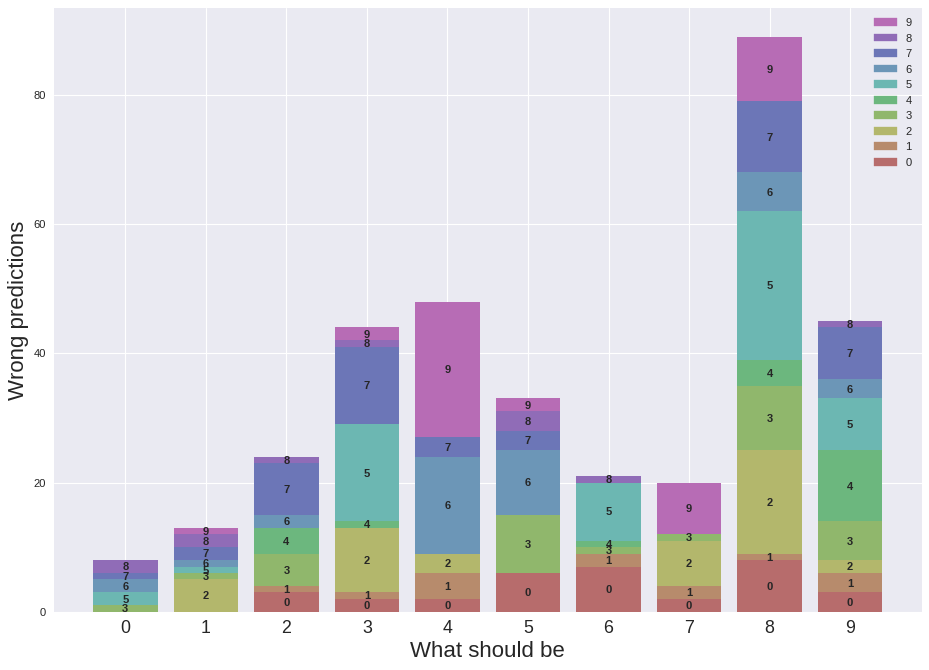

In [9]:
error_plot(decoded_mlp_predictions, expected)

From this chart we can see, that the most frequent errors are:
<ul>
<li>2 instead of 7</li>
<li>3 instead of 5</li>
<li>7 and 4 instead of 9</li>
<li>8 instead of 1, what isn't quite logical</li> 
</ul>


Now we're going to create more complex network, with two convolution layers. Convolution neural networks are slower, but are much more efficient on image recognition

In [4]:
cnn_model = Sequential([
    # input shape is (28, 28, 1), i.e. 28x28 pixels image with 1 color chanel (grayscale)
    
    ZeroPadding2D(padding=(1, 1), input_shape=(28, 28, 1)),
    Conv2D(64, (3, 3), activation='relu'),
    ZeroPadding2D(padding=(1, 1)),
    Conv2D(64, (3, 3), activation='relu'),
    AveragePooling2D(pool_size=(2, 2)),
    Dropout(0.5),
    
    ZeroPadding2D(padding=(1, 1)),
    Conv2D(64, (3, 3), activation='relu', strides=(2,2)),
    ZeroPadding2D(padding=(1, 1)),
    Conv2D(64, (3, 3), activation='relu', strides=(2,2)),
    AveragePooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    
    Flatten(),
    Dense(256, activation='relu', kernel_initializer='random_uniform'),
    Dropout(0.125),
    Dense(128, activation='relu', kernel_initializer='random_uniform'),
    Dropout(0.125),
    
    Dense(10, activation='softmax', kernel_initializer='random_uniform')
])

cnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In order to apply 2D convolution, we have to convert our train samples into (28, 28, 1) tensors

In [5]:
cnnTrainX = trainX.reshape(train_samples, 28, 28, 1)
cnnTestX = testX.reshape(test_samples, 28, 28, 1)

In [ ]:
cnn_model.fit(cnnTrainX, trainY, batch_size=50, epochs=10)

Epoch 1/10


Evaluating on test data

In [13]:
cnn_predictions = cnn_model.predict(cnnTestX)

decoded_cnn_predictions = decode_one_hot(cnn_predictions)
expected = testY.reshape(testY.shape[0])

print(evaluate_accuracy(decoded_cnn_predictions, expected))

model accuracy on test data: 98.730%


98.8% is significantly better result. It could come from CNN's ability to recognize spatial structure of images

Let's take a look at errors details

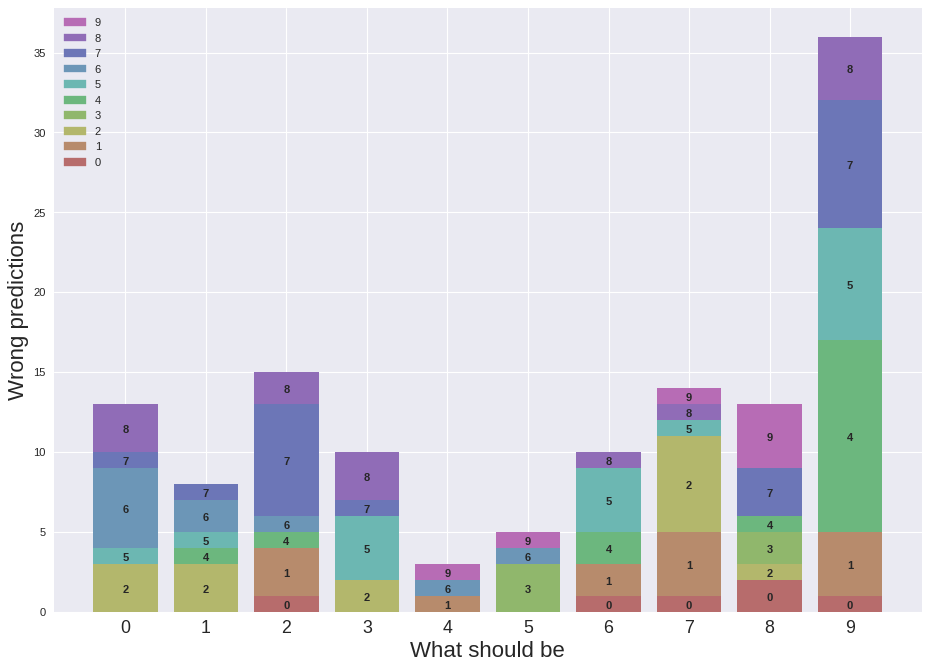

In [14]:
error_plot(decoded_cnn_predictions, expected)

Typical errors are:
* 5 instead of 3
* 9 instead of 4
* 0 and 5 instead of 6
* 1 and 2 instead of 7
* 0 and 9 instead of 9
* 4 instead of 9

This is much more like human could make a mistake, in opposite to simple MLP, which made a lot of errors like confusing 1 with 8 or 9 with 7